## Testing with the results of parallel computation. 

Tests the results of reading cluster_df using a single particle file. You should determine the exact particle file to read. 

Output the results as a pickle file of a dictionary containing Delta_sigma and the cluster_id. 

## Configuration

In [3]:
## testing multidark
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import h5py
import tables
import pickle5 as pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
from glob import glob
from time import time

In [4]:
from pygadgetreader import *

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from timeit import default_timer as timer

In [7]:
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/')

In [8]:
ptcl_dir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/'
clusters_dir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_ROCKSTAR_Halos/z0p00/'

## Importing the clusters

In [43]:
import pandas as pd
cluster_df = pd.read_csv(clusters_dir + 'clusters_SAGE_mvir_lgt_5e13.csv')

In [58]:
mvir_low = 1e14; mvir_high = 1e14
sample_num = 4

mask = (cluster_df.mvir >= mvir_low) & (cluster_df.mvir < mvir_high)
cur_df = cluster_df[mask]
#cur_df = cur_df.head(sample_num) ##Get the first X number of clusters

In [67]:
np.log10(2)

0.3010299956639812

## Configuring the Delta Sigma reading. 

In [72]:
##Global variables
box_length = 1000
ptcl_mass = 1.505e9 ##Msun/h
dz = 200 ## Projection depth Mpc/h
r_range_norm = np.logspace(0,1,10)

## Computing Delta Sigma (without parallelization)

In [23]:
output = {}

x = np.array(cur_df.x); y = np.array(cur_df.y); z = np.array(cur_df.z)
mvir = np.array(cur_df.mvir); rvir = np.array(cur_df.rvir)/1000
Ngal = np.array(cur_df.Ngal)
cluster_id = np.array(cur_df.id)
        
#Derived quantities
r_range = r_range_norm*rvir[:,np.newaxis]
sigma = np.zeros((sample_num, len(r_range_norm)-1))

## Compute Delta Sigma
start = time()
ptcl_files = glob(ptcl_dir + 'snap_130.*')
#ptcl_files = [str(ptcl_dir + 'snap_130.0')]

for file in ptcl_files:
    ptcl = readsnap(file, 'pos', 'dm', nth=10, suppress=1, single=True)

    print("Completed particle file: ", file)
            
    for i in range(sample_num):
        r_range_cl = r_range[i]
        sigma_cl = np.zeros(len(r_range_cl)-1)
        
        ##Periodic boundary condition for annulus. Halos are conditions at [0,1000] Mpc boundaries.       
        dx_sqr = np.asarray([(ptcl[:,0]-x[i])**2, (ptcl[:,0]-x[i]+box_length)**2, (ptcl[:,0]-x[i]-box_length)**2]).min(0)
        dy_sqr = np.asarray([(ptcl[:,1]-y[i])**2, (ptcl[:,1]-y[i]+box_length)**2, (ptcl[:,1]-y[i]-box_length)**2]).min(0)
        dz_min = np.asarray([np.abs(ptcl[:,2]-z[i]), np.abs(ptcl[:,2]-z[i]+box_length), np.abs(ptcl[:,2]-z[i]-box_length)]).min(0)

        for j in range(len(r_range_cl)-1):
            #radius for annulus
            dr = r_range_cl[j+1] - r_range_cl[j]
            r_cur = r_range_cl[j]

            #Masking
            mask = dx_sqr + dy_sqr <= (r_cur+dr)**2
            mask &= dz_min < dz

            #Building an annulus
            annulus_df = ptcl[mask]

            #Find 2D density within the annulus
            area = np.pi * ((r_cur+dr)**2 - (r_cur)**2.)

            m_tot = len(annulus_df)*ptcl_mass

            sigma_cl[j] = m_tot/area
                
        sigma[i] += sigma_cl
    
    
end = time()
print("Time elapsed  = ", end-start)


output['cluster_id'] = cluster_id
output['sigma'] = sigma

with open("test_cluster_DS.pkl", "wb") as handle:
    pickle.dump(output, handle)
    
print("Done")

Completed particle file:  /global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/snap_130.967
Completed particle file:  /global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/snap_130.350
Completed particle file:  /global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/snap_130.1132
Completed particle file:  /global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/snap_130.835
Completed particle file:  /global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/snap_130.517
Completed particle file:  /global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/snap_130.692
Completed particle file:  /global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/snap_130.89
Completed particle file:  /global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/snap_130.20
Completed particle file:  /global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/snap_130.790
Completed particle file:  /global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/snap

In [24]:
output['sigma']

array([[1.76996039e+13, 1.45245822e+13, 1.19732344e+13, 1.05923565e+13,
        9.94670862e+12, 9.06672049e+12, 8.57290301e+12, 8.40904444e+12,
        8.20851594e+12],
       [1.60694189e+13, 1.30915513e+13, 1.10381744e+13, 9.33237462e+12,
        8.60879302e+12, 8.08814387e+12, 7.95202721e+12, 7.67561525e+12,
        7.48038563e+12],
       [1.83978208e+13, 1.53567288e+13, 1.31869996e+13, 1.15639929e+13,
        1.06045238e+13, 1.04977373e+13, 1.03321501e+13, 9.60612419e+12,
        8.54670086e+12],
       [1.73183032e+13, 1.34724273e+13, 1.06678505e+13, 9.17079295e+12,
        8.04248107e+12, 7.64986811e+12, 7.64716618e+12, 7.03536478e+12,
        7.03536677e+12]])

## Importing the different files 
* test_cluster_DS_n4.pkl for non-parallelized code. 
* test_parallel_DS_n4.pkl for parallelized code. 

In [ ]:
import pickle
with open('test_cluster_DS_n4.pkl', 'rb') as handle:
    cl_serial = pickle.load(handle)
    
with open('test_parallel_DS_n4.pkl', 'rb') as handle:
    cl_mpi = pickle.load(handle)
    

In [ ]:
cl_serial['sigma'] - cl_mpi['sigma']

ValueError: operands could not be broadcast together with shapes (4,9) (1000,9) 

In [29]:
cl_mpi['sigma']

array([[1.76996039e+13, 1.45245822e+13, 1.19732344e+13, 1.05923565e+13,
        9.94670862e+12, 9.06672049e+12, 8.57290301e+12, 8.40904444e+12,
        8.20851594e+12],
       [1.60694189e+13, 1.30915513e+13, 1.10381744e+13, 9.33237462e+12,
        8.60879302e+12, 8.08814387e+12, 7.95202721e+12, 7.67561525e+12,
        7.48038563e+12],
       [1.83978208e+13, 1.53567288e+13, 1.31869996e+13, 1.15639929e+13,
        1.06045238e+13, 1.04977373e+13, 1.03321501e+13, 9.60612419e+12,
        8.54670086e+12],
       [1.73183032e+13, 1.34724273e+13, 1.06678505e+13, 9.17079295e+12,
        8.04248107e+12, 7.64986811e+12, 7.64716618e+12, 7.03536478e+12,
        7.03536677e+12]])

In [30]:
cl_serial['sigma']

array([[1.76996039e+13, 1.45245822e+13, 1.19732344e+13, 1.05923565e+13,
        9.94670862e+12, 9.06672049e+12, 8.57290301e+12, 8.40904444e+12,
        8.20851594e+12],
       [1.60694189e+13, 1.30915513e+13, 1.10381744e+13, 9.33237462e+12,
        8.60879302e+12, 8.08814387e+12, 7.95202721e+12, 7.67561525e+12,
        7.48038563e+12],
       [1.83978208e+13, 1.53567288e+13, 1.31869996e+13, 1.15639929e+13,
        1.06045238e+13, 1.04977373e+13, 1.03321501e+13, 9.60612419e+12,
        8.54670086e+12],
       [1.73183032e+13, 1.34724273e+13, 1.06678505e+13, 9.17079295e+12,
        8.04248107e+12, 7.64986811e+12, 7.64716618e+12, 7.03536478e+12,
        7.03536677e+12]])

In [36]:
sigma_mpi_mean = np.mean(cl_mpi['sigma'], axis=0)
sigma_serial_mean = np.mean(cl_serial['sigma'], axis=0)


TypeError: _mean_dispatcher() got multiple values for argument 'axis'

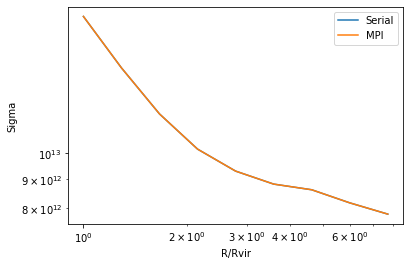

In [42]:
plt.plot(r_range_norm[:-1], sigma_serial_mean, label='Serial')
plt.plot(r_range_norm[:-1], sigma_mpi_mean, label='MPI')
plt.xlabel('R/Rvir')
plt.ylabel('Sigma')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

## Test parallelized code alone

In [11]:
import pickle
    
with open('sigma_mvir_1e14_2e14_z0p00.pkl', 'rb') as handle:
    cl_mpi = pickle.load(handle)
    
r_range_norm = np.logspace(-0.15,1,10)

In [17]:
sigma_mpi_mean = np.mean(cl_mpi['sigma'], axis=0)
DS_mpi_mean = np.mean(cl_mpi['delta_sigma'], axis=0)

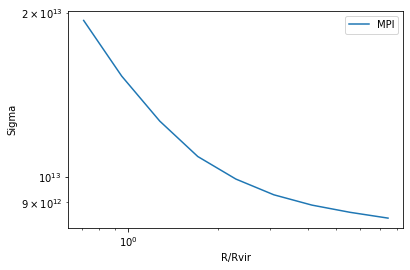

In [18]:
plt.plot(r_range_norm[:-1], sigma_mpi_mean, label='MPI')
plt.xlabel('R/Rvir')
plt.ylabel('Sigma')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

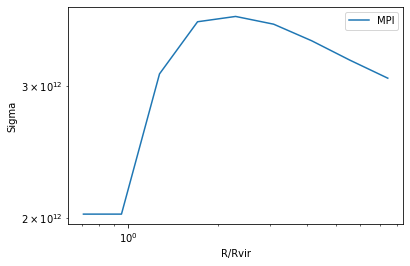

In [19]:
plt.plot(r_range_norm[:-1], DS_mpi_mean, label='MPI')
plt.xlabel('R/Rvir')
plt.ylabel('Delta_Sigma')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [15]:
cl_mpi['delta_sigma']

array([[2.26865284e+12, 2.26865284e+12, 3.29308260e+12, ...,
        2.95977665e+12, 2.35747723e+12, 1.98875466e+12],
       [2.08034578e+12, 2.08034578e+12, 3.13199979e+12, ...,
        3.35841899e+12, 2.86669328e+12, 2.59476640e+12],
       [1.83527484e+12, 1.83527484e+12, 2.91449509e+12, ...,
        2.06756329e+12, 1.74774893e+12, 1.91151399e+12],
       ...,
       [3.57856770e+12, 3.57856770e+12, 5.44118013e+12, ...,
        5.36399144e+12, 4.96777494e+12, 4.50226451e+12],
       [1.40658853e+12, 1.40658853e+12, 2.33316998e+12, ...,
        4.63694580e+12, 4.59436271e+12, 3.91160039e+12],
       [2.24024797e+12, 2.24024797e+12, 3.44109761e+12, ...,
        3.57942689e+12, 3.06414127e+12, 2.46514635e+12]])

In [16]:
cl_mpi['r_range']

array([[ 0.83650518,  1.12265525,  1.50669098, ...,  6.56013956,
         8.80421939, 11.81594971],
       [ 0.78267304,  1.05040832,  1.40972996, ...,  6.13797081,
         8.23763598, 11.05555054],
       [ 0.76861463,  1.03154083,  1.38440832, ...,  6.02772028,
         8.08967116, 10.85697021],
       ...,
       [ 0.80671623,  1.08267616,  1.45303593, ...,  6.32652518,
         8.49069066, 11.39516968],
       [ 0.8023716 ,  1.07684532,  1.44521048, ...,  6.29245315,
         8.44496334, 11.33380005],
       [ 0.78702476,  1.05624867,  1.41756817, ...,  6.1720984 ,
         8.28343787, 11.11702026]])